# Imports

In [1]:
try:
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN
    print("Library is already installed.")
except ImportError:
    print("Library is not installed. Proceed with installation.")
    !pip install fancyimpute
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import re

Library is already installed.


### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
df_data.isna().sum()

author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64

In [5]:
df_og.isna().sum()

author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns. The original data could be very he puff for that purpose since it does not contain any missing values.

In [6]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [7]:
df_data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [8]:
df_og.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


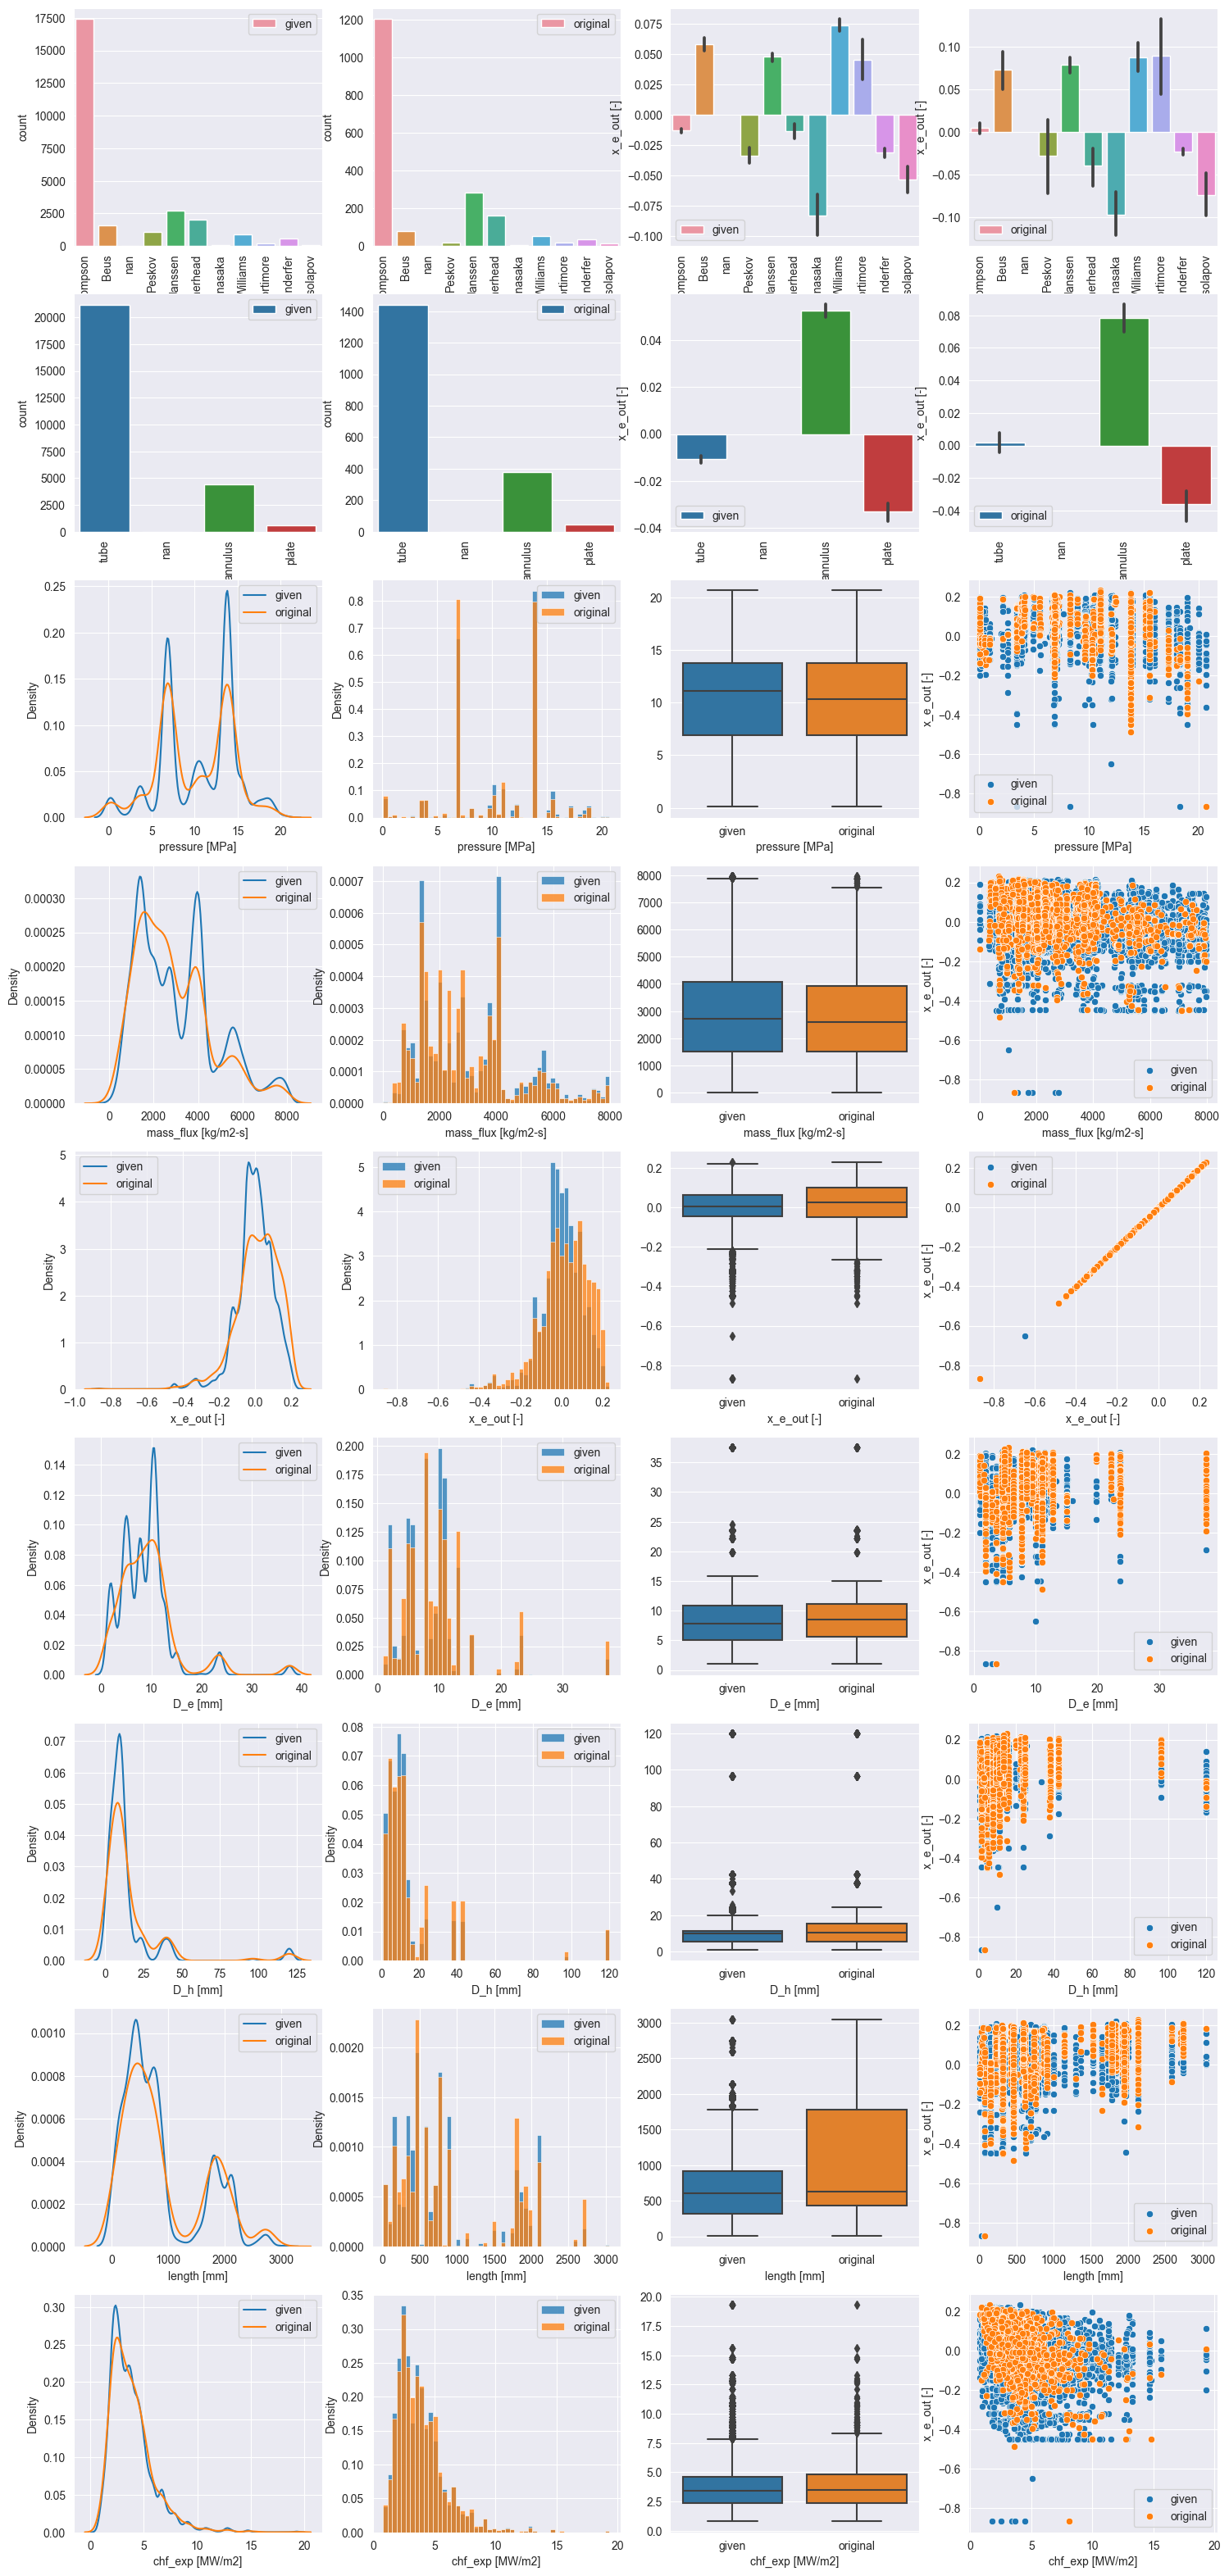

In [9]:
fig, axes = plt.subplots(nrows=len(df_data.columns), ncols=4, figsize=(18, 40))
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Plot densities
    for df, column, label in data:
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False)
    for df, column, label in data:
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50)

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2])
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for df, column, label in data:
        sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Makes sure that the categories are shown in the same order
    category_order: list[str] = data[0][0][data[0][1]].unique()

    # Plot barplots
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.countplot(x=column, data=df, label=label, order=category_order, ax=axes[axes_start_i + il])
        axes[axes_start_i + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot target correlation
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.barplot(x=column, y=target, data=df, label=label, order=category_order, ax=axes[axes_start_i + 2 + il])
        axes[axes_start_i + 2 + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 2].legend()
    axes[axes_start_i + 3].legend()


i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        graph_numerical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    else:
        graph_categorical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    i += 4

plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

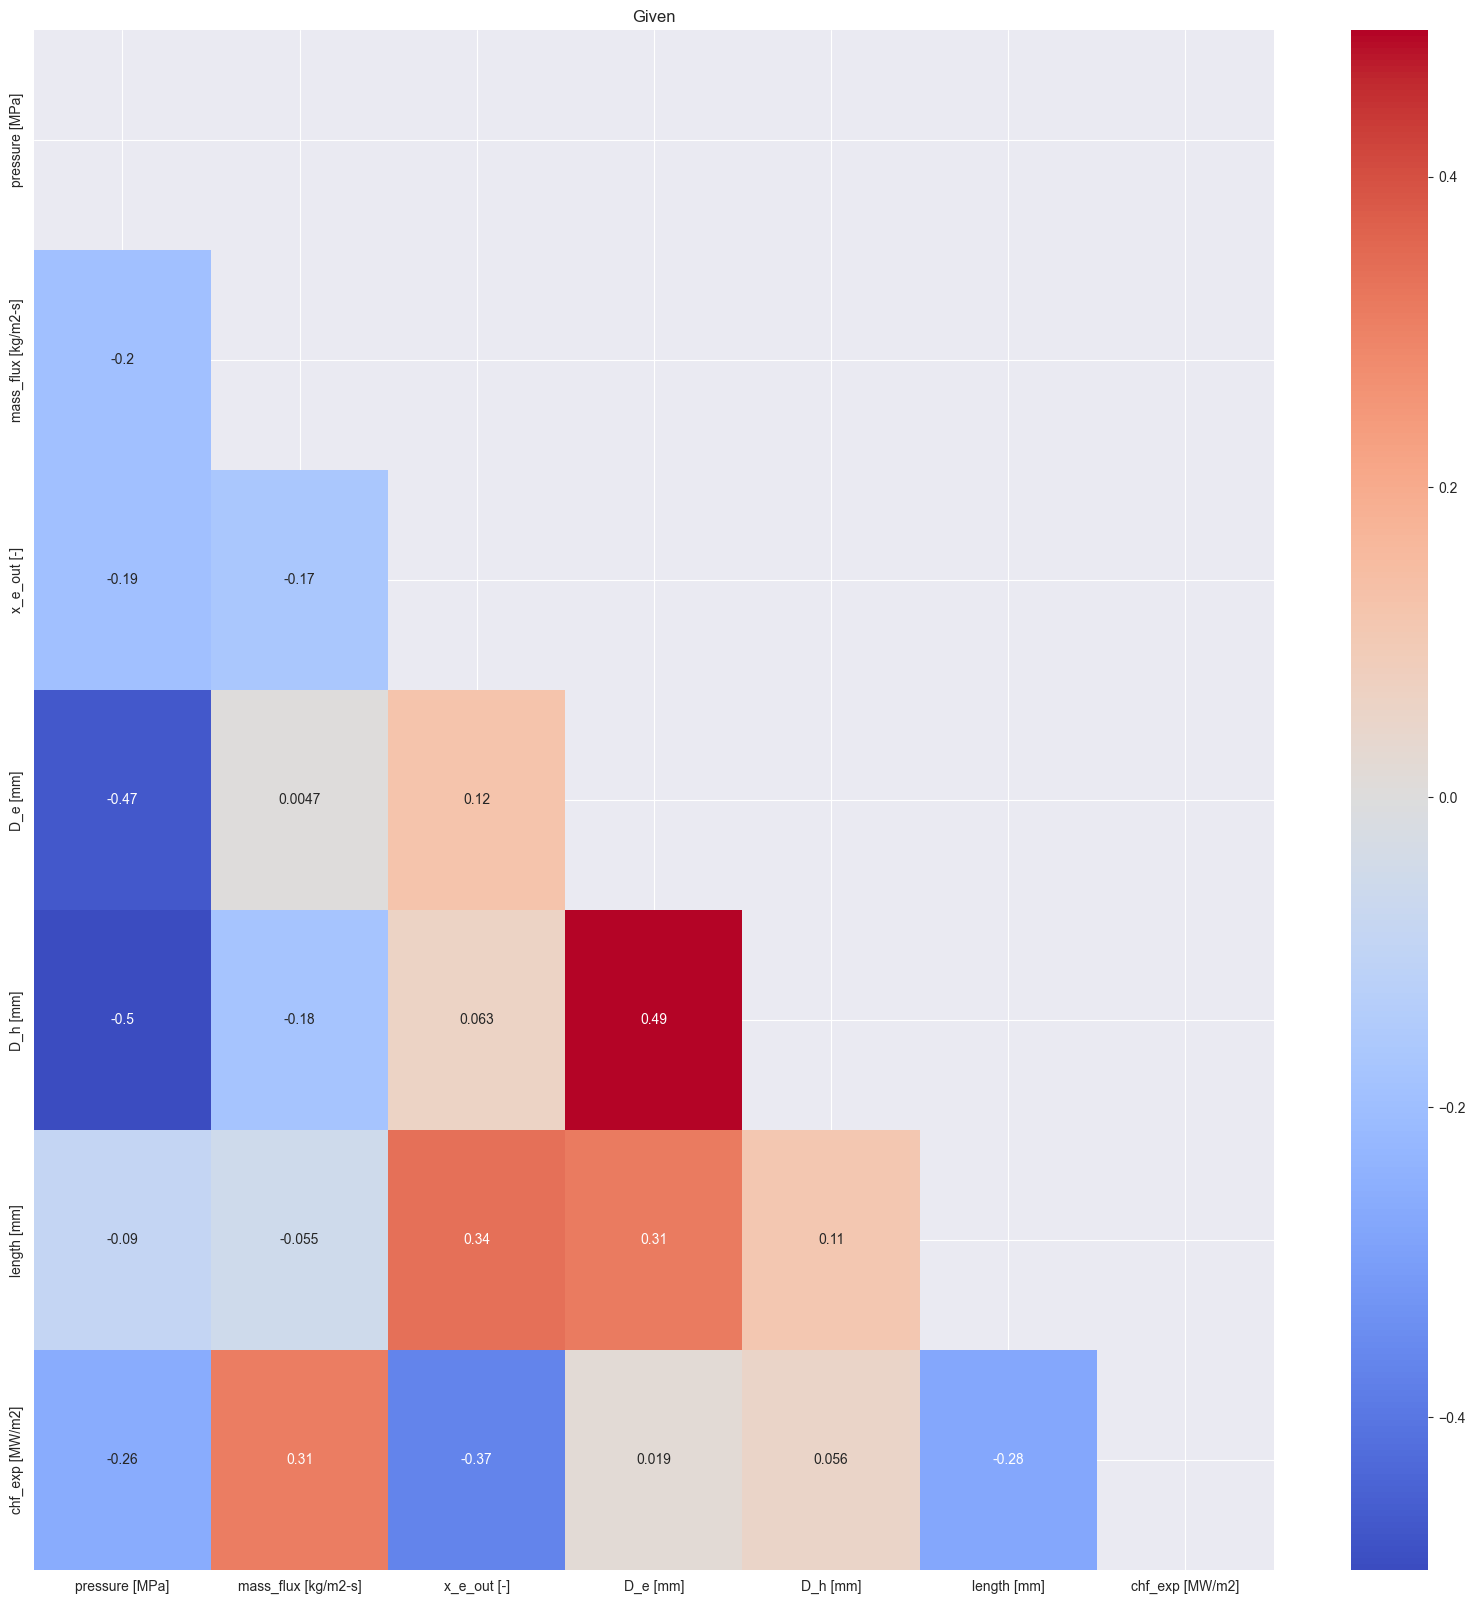

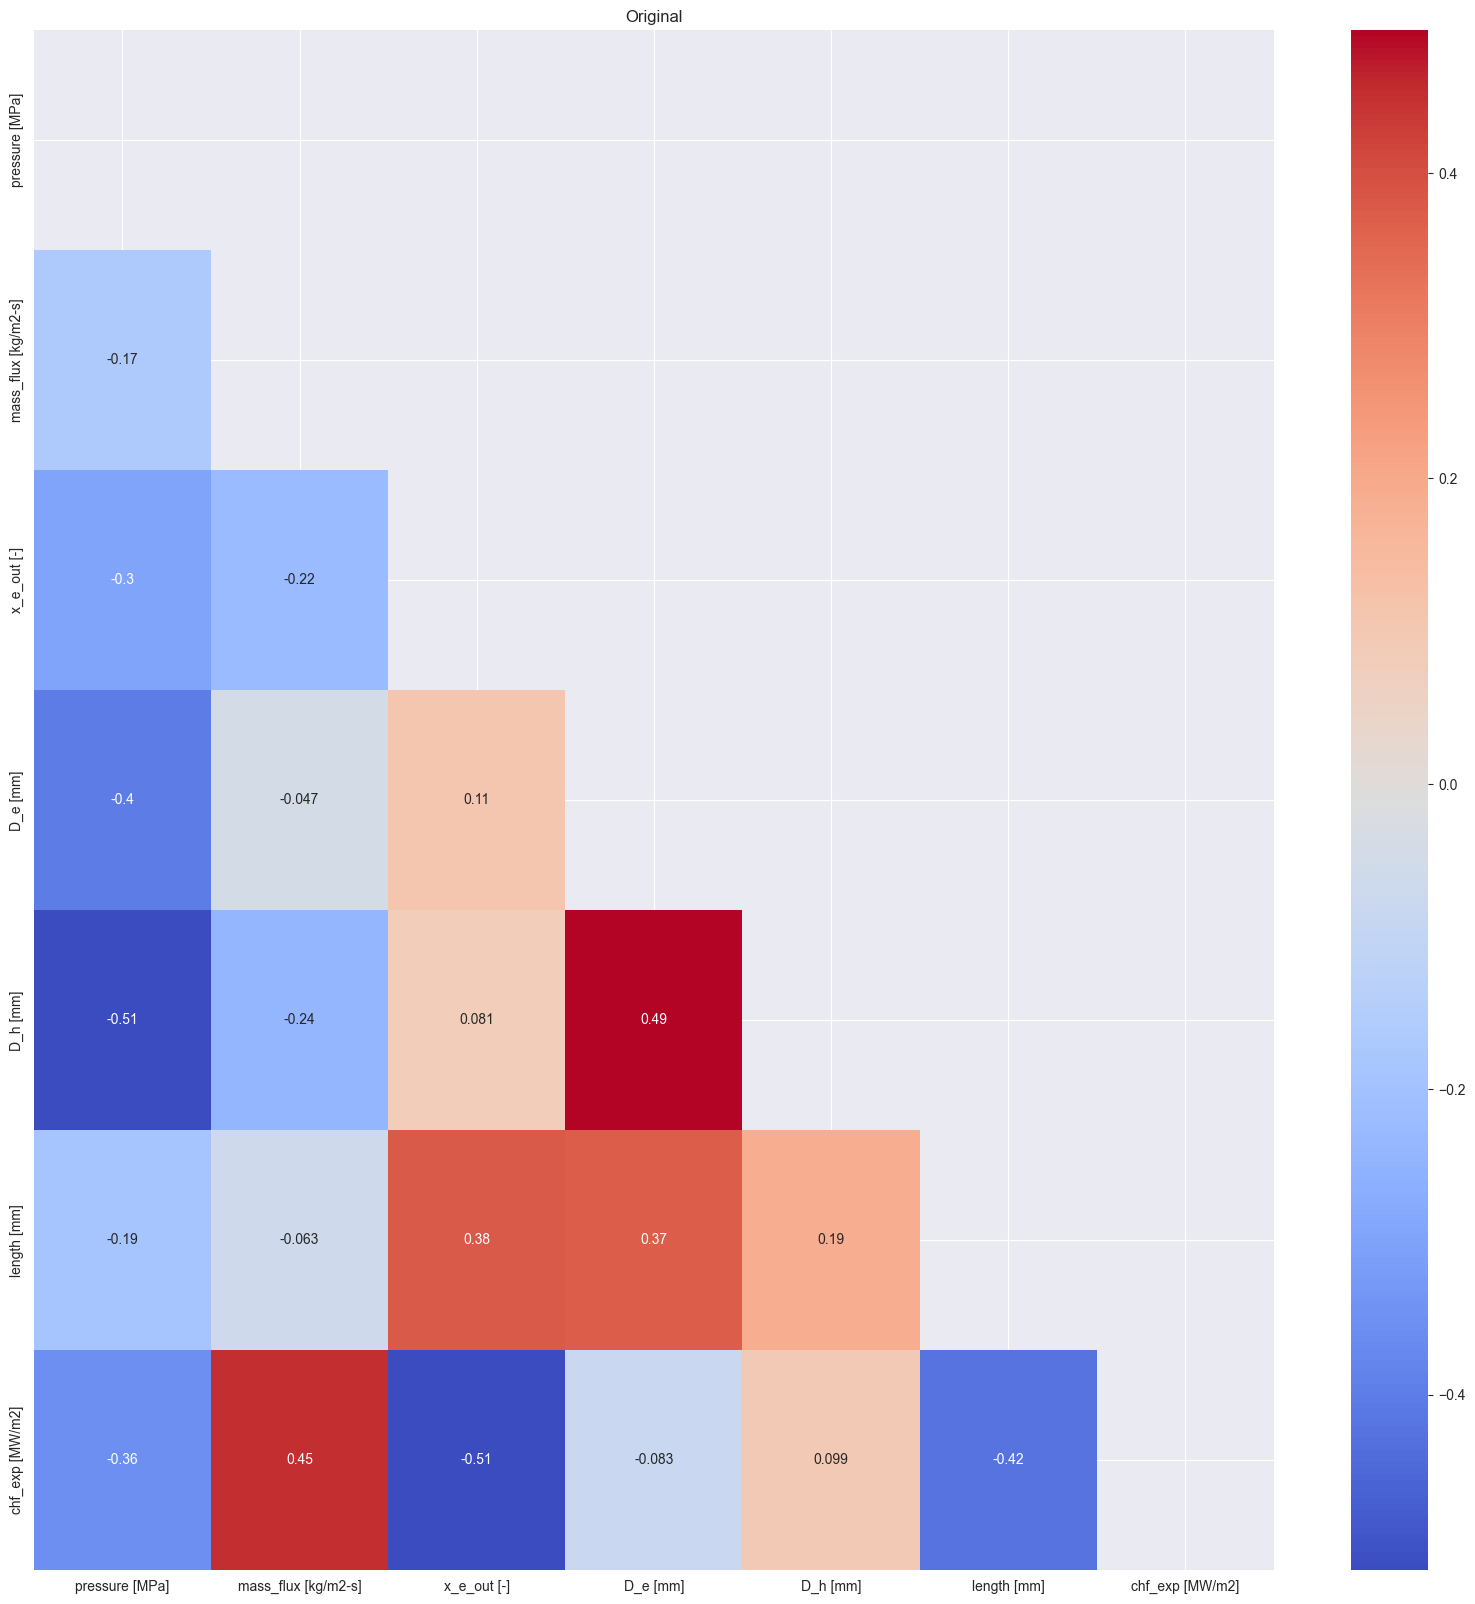

In [10]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(20, 20))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_data, "Given")
show_feature_correlation(df_og, "Original")

# Data Prep

In [11]:
numerical_columns = ['pressure [MPa]', 'mass_flux [kg/m2-s]','x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
numerical_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
categorical_columns = ['author', 'geometry']
target = 'x_e_out [-]'

In [12]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    for column in numerical_features:
        column_values = df[column].values  # No need to reshape column values
        not_nan_values = column_values[~pd.isnull(column_values)]  # Filter non-NaN values

        if not_nan_values.size > 0:  # Check if there are any non-NaN values
            not_nan_values = not_nan_values.reshape(-1, 1)  # Reshape to 2D array with single column
            standard_scaler = StandardScaler()
            normalized_values = standard_scaler.fit_transform(not_nan_values)

            # Create a mask to identify non-NaN values in the column
            mask = ~pd.isnull(df[column])
            # Replace the non-NaN values with normalized values in the original DataFrame
            df.loc[mask, column] = normalized_values.flatten()

    return df

In [13]:
df_train: pd.DataFrame = pd.concat([df_data, df_og])
df_train.reset_index(inplace=True, drop=True)

In [14]:
normalize(df_train)

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,Thompson,tube,-0.830902,0.404113,0.1754,NaN,-0.175731,-0.600507,-0.100901
1,Thompson,tube,NaN,1.691601,-0.0416,0.306885,-0.200815,-0.112494,-1.008131
2,Thompson,NaN,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,0.100706
3,Beus,annulus,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.856926
4,NaN,tube,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147
...,...,...,...,...,...,...,...,...,...
33504,Richenderfer,plate,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,-0.000098
33505,Richenderfer,plate,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,-0.151303
33506,Richenderfer,plate,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,-0.856926
33507,Richenderfer,plate,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,1.108739


In [15]:
#label_encode(df_train)

In [16]:
df_train = one_hot_encode(df_train)

In [17]:
df_train

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,-0.830902,0.404113,0.1754,NaN,-0.175731,-0.600507,-0.100901,0,0,0,0,0,0,0,1,0,0,0,0,1
1,NaN,1.691601,-0.0416,0.306885,-0.200815,-0.112494,-1.008131,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,0.100706,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.856926,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,-0.000098,0,0,0,0,0,0,1,0,0,0,0,1,0
33505,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,-0.151303,0,0,0,0,0,0,1,0,0,0,0,1,0
33506,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,-0.856926,0,0,0,0,0,0,1,0,0,0,0,1,0
33507,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,1.108739,0,0,0,0,0,0,1,0,0,0,0,1,0


# Train

## Baseline 0: Impute all missing numerical value including target using MICE

In [18]:
# Create an instance of imputer
imputer = IterativeSVD()
#imputer = KNN()

# Perform the imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)
# Print the imputed DataFrame
print("Imputed DataFrame:")
df_train_imputed

[IterativeSVD] Iter 1: observed MAE=0.265744
[IterativeSVD] Iter 2: observed MAE=0.230331
[IterativeSVD] Iter 3: observed MAE=0.157206
[IterativeSVD] Iter 4: observed MAE=0.055924
[IterativeSVD] Iter 5: observed MAE=0.036299
[IterativeSVD] Iter 6: observed MAE=0.036431
[IterativeSVD] Iter 7: observed MAE=0.036529
[IterativeSVD] Iter 8: observed MAE=0.036597
[IterativeSVD] Iter 9: observed MAE=0.036636
[IterativeSVD] Iter 10: observed MAE=0.036652
[IterativeSVD] Iter 11: observed MAE=0.036649
[IterativeSVD] Iter 12: observed MAE=0.036628
[IterativeSVD] Iter 13: observed MAE=0.036594
[IterativeSVD] Iter 14: observed MAE=0.036549
[IterativeSVD] Iter 15: observed MAE=0.036495
[IterativeSVD] Iter 16: observed MAE=0.036434
[IterativeSVD] Iter 17: observed MAE=0.036368
[IterativeSVD] Iter 18: observed MAE=0.036297
[IterativeSVD] Iter 19: observed MAE=0.036222
[IterativeSVD] Iter 20: observed MAE=0.036146
[IterativeSVD] Iter 21: observed MAE=0.036069
[IterativeSVD] Iter 22: observed MAE=0.0359

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,-0.830902,0.404113,0.175400,-0.317140,-0.175731,-0.600507,-0.100901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.645289,1.691601,-0.041600,0.306885,-0.200815,-0.112494,-1.008131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.736130,-0.576615,0.033500,-0.186164,-0.331250,-0.563536,0.100706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.736130,0.352704,-0.027900,-0.584395,0.045006,1.916454,-0.856926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.736130,-1.338148,-0.005187,0.458592,-0.160681,-0.563536,-1.512147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.021800,1.198165,5.302565,-1.224571,-0.000098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33505,-2.213306,-0.878291,-0.043400,1.198165,5.302565,-1.224571,-0.151303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33506,-2.213306,-0.595823,-0.010900,1.198165,5.302565,-1.224571,-0.856926,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33507,-2.213306,-0.595823,-0.021800,1.198165,5.302565,-1.224571,1.108739,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
df_train_imputed.isna().sum()

pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
author_Beus            0
author_Inasaka         0
author_Janssen         0
author_Kossolapov      0
author_Mortimore       0
author_Peskov          0
author_Richenderfer    0
author_Thompson        0
author_Weatherhead     0
author_Williams        0
geometry_annulus       0
geometry_plate         0
geometry_tube          0
dtype: int64

## Baseline 1: Tree boosting on imputed data

### Construct new training data

In [20]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[f'{column}_was_an'] = df_train[column].isna().astype(int)

In [21]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[column] = df_train_imputed[column]

In [22]:
df_test = df_train[df_train[target].isna()]
df_train = df_train[~df_train[target].isna()]

In [23]:
def remove_special_characters(column_name):
    # Remove special characters using regular expressions
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    # Remove special characters from all column names in the DataFrame
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

df_test = remove_special_characters_from_dataframe(df_test)
df_train = remove_special_characters_from_dataframe(df_train)

In [24]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'num_leaves': trial.suggest_int('num_leaves', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm.best_params
best_mae = study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 22:56:51,691] A new study created in memory with name: no-name-a9e9291c-c5af-4765-95e8-a7183a533333
[I 2023-05-17 22:56:53,005] Trial 0 finished with value: 0.056543300925621216 and parameters: {'max_depth': 8, 'num_leaves': 7, 'learning_rate': 0.08082697354178911, 'min_child_samples': 13, 'reg_alpha': 1.0139547079379472, 'reg_lambda': 8.966119250686333, 'force_col_wise': True}. Best is trial 0 with value: 0.056543300925621216.
[I 2023-05-17 22:56:54,250] Trial 1 finished with value: 0.054709133138510155 and parameters: {'max_depth': 7, 'num_leaves': 9, 'learning_rate': 0.06817983355493723, 'min_child_samples': 5, 'reg_alpha': 0.02005238570039264, 'reg_lambda': 7.9320818158056605, 'force_col_wise': True}. Best is trial 1 with value: 0.054709133138510155.
[I 2023-05-17 22:56:55,523] Trial 2 finished with value: 0.05805595596879796 and parameters: {'max_depth': 4, 'num_leaves': 7, 'learning_rate': 0.01193655747628262, 'min_child_samples': 15, 'reg_alpha': 1.0432035707695497

Best Parameters: {'max_depth': 7, 'num_leaves': 9, 'learning_rate': 0.07450157391105641, 'min_child_samples': 19, 'reg_alpha': 0.03318547706690286, 'reg_lambda': 8.010284164101403, 'force_col_wise': False}
Best MAE: 0.054162237777005816


In [25]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': 1000,
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=50)

# Print the best parameters and the best MAE
best_params = study_catboost.best_params
best_mae = study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 22:58:45,077] A new study created in memory with name: no-name-9ec990b4-1f98-4c41-b530-0bc493142eb0
[I 2023-05-17 22:58:47,500] Trial 0 finished with value: 0.05544815025236174 and parameters: {'depth': 4, 'learning_rate': 0.097046775388042, 'l2_leaf_reg': 7.024808296459695, 'random_strength': 7.199344183744454, 'bagging_temperature': 0.5285221666992872, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.05544815025236174.
[I 2023-05-17 22:58:50,178] Trial 1 finished with value: 0.05865137528239387 and parameters: {'depth': 3, 'learning_rate': 0.017883950647639854, 'l2_leaf_reg': 1.7859303182973758, 'random_strength': 3.2958227479115454, 'bagging_temperature': 0.8716989449685201, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.05544815025236174.
[I 2023-05-17 22:58:54,318] Trial 2 finished with value: 0.05465793176526374 and parameters: {'depth': 5, 'learning_rate': 0.08471155936986033, 'l2_leaf_reg': 8.729321155355615, 'random_strength': 8.78291870

Best Parameters: {'depth': 5, 'learning_rate': 0.09360805021523999, 'l2_leaf_reg': 8.82032042591127, 'random_strength': 5.631380603692046, 'bagging_temperature': 0.9330321048757269, 'grow_policy': 'SymmetricTree'}
Best MAE: 0.054219099266938034


In [26]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'grow_policy': 'lossguide',
        'eta': trial.suggest_float('eta', 0.01, 1),
        'early_stopping_rounds': 100,
        'huber_slope': trial.suggest_float('huber_slope', 0.01, 1),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_xgboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_xgboost.best_params
best_mae = study_xgboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 23:02:01,114] A new study created in memory with name: no-name-6a1dfeef-3a53-41b3-b28b-35f6ba122cb6
[I 2023-05-17 23:02:01,218] Trial 0 finished with value: 0.18533295271777053 and parameters: {'max_depth': 5, 'learning_rate': 0.07968976313027153, 'min_child_weight': 5.113459057840256, 'gamma': 3.6751162013387217, 'subsample': 0.5158918124958224, 'colsample_bytree': 0.8827830296265822, 'reg_alpha': 2.519039838438108, 'reg_lambda': 6.276024620886481, 'eta': 0.2182086020713129, 'huber_slope': 0.7435905069863109}. Best is trial 0 with value: 0.18533295271777053.
[I 2023-05-17 23:02:01,297] Trial 1 finished with value: 0.15394918512549075 and parameters: {'max_depth': 4, 'learning_rate': 0.07511393447846423, 'min_child_weight': 7.707349161007226, 'gamma': 7.44326440298863, 'subsample': 0.5659782151419057, 'colsample_bytree': 0.7468693881378653, 'reg_alpha': 1.30738665290851, 'reg_lambda': 4.659281994709032, 'eta': 0.034318800998715725, 'huber_slope': 0.39723281650554126}. Bes

Best Parameters: {'max_depth': 6, 'learning_rate': 0.09678938023303464, 'min_child_weight': 6.330446662189057, 'gamma': 0.602259520711212, 'subsample': 0.8406268559943381, 'colsample_bytree': 0.9215653154302436, 'reg_alpha': 1.198533001596216, 'reg_lambda': 8.44187556030476, 'eta': 0.9317578757247391, 'huber_slope': 0.14295921307033566}
Best MAE: 0.06841260669423606


In [27]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': 500,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest regressor
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_rf = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_rf.optimize(objective, n_trials=50)

# Print the best parameters and the best MAE
best_params = study_rf.best_params
best_mae = study_rf.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 23:02:12,095] A new study created in memory with name: no-name-a24111ba-5a81-4792-a851-20bed334a14b
[I 2023-05-17 23:02:13,925] Trial 0 finished with value: 0.06538954367373634 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.06538954367373634.
[I 2023-05-17 23:02:16,735] Trial 1 finished with value: 0.06176457903531713 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.06176457903531713.
[I 2023-05-17 23:02:19,058] Trial 2 finished with value: 0.0627851366923799 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.06176457903531713.
[I 2023-05-17 23:02:20,786] Trial 3 finished with value: 0.06538000701470707 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is

Best Parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None}
Best MAE: 0.05910285223780342


In [28]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**study_lgbm.best_params)
        elif model_type == 'CatBoost':
            self.model = CatBoostRegressor(**study_catboost.best_params)
        elif model_type == 'XGBoost':
            self.model = xgb.XGBRegressor(**study_xgboost.best_params)
        elif model_type == 'RandomForest':
            self.model = RandomForestRegressor(**study_rf.best_params)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['RandomForest']:
            self.model.fit(X, y.ravel())
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [29]:
def train(model_type):
    X = df_train.drop(['x_e_out'], axis=1)
    y = df_train['x_e_out']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('x_e_out', axis=1)
        y_train = train_dataframe['x_e_out']
        X_dev = dev_dataframe.drop('x_e_out', axis=1)
        y_dev = dev_dataframe['x_e_out']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [30]:
supported_models = ['LightGBM', 'CatBoost', 'XGBoost', 'RandomForest']

In [31]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


-------------------- LightGBM -------------------- 
Fold 0 loss: 0.05908343582003789
Fold 1 loss: 0.06022551001737776


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 0.05841132244386166


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 0.0590843034498577


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 0.05903364495535863
Mean loss: 0.05916764333729872
-------------------- CatBoost -------------------- 
Fold 0 loss: 0.05452700337501964
Fold 1 loss: 0.05643679159780878
Fold 2 loss: 0.054820558208018746
Fold 3 loss: 0.05469506844743885
Fold 4 loss: 0.05506693495011594
Mean loss: 0.0551092713156804
-------------------- XGBoost -------------------- 
Fold 0 loss: 0.06197154982586152
Fold 1 loss: 0.06346104924549478
Fold 2 loss: 0.06086442538589078
Fold 3 loss: 0.06258189366147596
Fold 4 loss: 0.062127740938396625
Mean loss: 0.062201331811423934
-------------------- RandomForest -------------------- 
Fold 0 loss: 0.058978704035670654
Fold 1 loss: 0.06060303682314558
Fold 2 loss: 0.05913489607879463
Fold 3 loss: 0.059134485782951954
Fold 4 loss: 0.05930457010323869
Mean loss: 0.0594311385647603


## Calculate assembly weights

In [32]:
model_predictions_on_validation = {'model_name': [], 'x': [], 'y': []}
def calc_model_predictions_on_validation(pipelines, eval_sets_idx):
    predictions = None
    ground_truth = None

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        if predictions is None:
            predictions = np.array(prediction).flatten()
            ground_truth = np.array(y_dev).flatten()
        else:
            predictions = np.concatenate((predictions,  np.array(prediction).flatten()))
            ground_truth = np.concatenate((ground_truth,  np.array(y_dev).flatten()))

    model_predictions_on_validation['model_name'].append(model_name)
    model_predictions_on_validation['x'].append(predictions)
    model_predictions_on_validation['y'].append(ground_truth) # Should be the same for all models

for model_name in supported_models:
    calc_model_predictions_on_validation(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets'])

In [33]:
def eval_assembly_on_validation(weights):
    #weights = weights / np.sum(weights, axis=0, keepdims=True)
    prediction = 0

    for model_id, x in enumerate(model_predictions_on_validation['x']):
        prediction += x * weights[model_id]

    return mean_absolute_error(model_predictions_on_validation['y'][0], prediction)

In [34]:
# Set initial weights
model_weights = np.array([0.25, 0.25, 0.25, 0.25])
# Define the optimization bounds
bounds = [(0, 0.5)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
#optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())

0.9994394219394676
0.9994394219394676


In [35]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(model_predictions_on_validation['model_name'])):
    df_optimal_model_weights['model_name'].append(model_predictions_on_validation['model_name'][i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {model_predictions_on_validation['model_name'][i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

0.167 LightGBM
0.500 CatBoost
0.000 XGBoost
0.333 RandomForest


In [36]:
performance_data = {'model_name': [], 'training_loss': [], 'og_data_excluded': []}
def get_loss(pipelines, eval_sets_idx):
    losses = []

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        loss = mean_absolute_error(y_dev, prediction)
        losses.append(loss)

    return np.array(losses).mean()

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['training_loss'].append(np.array(train_results[f'{model_name}_losses']).mean())
    performance_data['og_data_excluded'].append(get_loss(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets']))
performance_data = pd.DataFrame(performance_data)

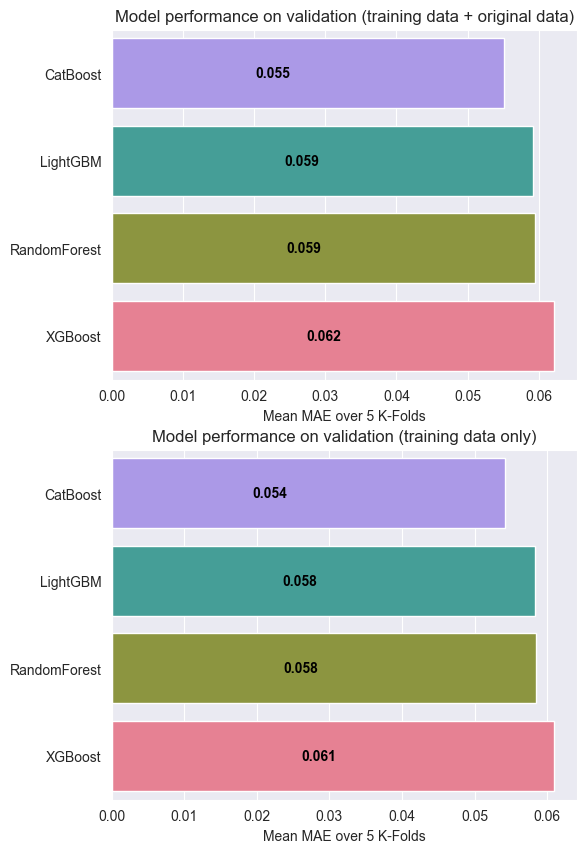

In [37]:
loss_eval_types: list[str] = ['training_loss', 'og_data_excluded']
fig, axes = plt.subplots(nrows=len(loss_eval_types), ncols=1, figsize=(6, 10))
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]
titles = ['Model performance on validation (training data + original data)',
          'Model performance on validation (training data only)']

for ax_index, loss_eval_type in enumerate(loss_eval_types):
    performance_data.sort_values(loss_eval_type, ascending=True, inplace=True)
    sns.barplot(x=loss_eval_type, y='model_name', data=performance_data, ax=axes[ax_index], palette=palette_reversed)
    for i, v in enumerate(performance_data[loss_eval_type]):
        axes[ax_index].text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    axes[ax_index].set(ylabel=None)
    axes[ax_index].set(xlabel="Mean MAE over 5 K-Folds")
    axes[ax_index].set_title(titles[ax_index])
plt.show()

In [38]:
performance_data

,model_name,training_loss,og_data_excluded
1,CatBoost,0.055109,0.054236
0,LightGBM,0.059168,0.058320
3,RandomForest,0.059431,0.058466
2,XGBoost,0.062201,0.060998


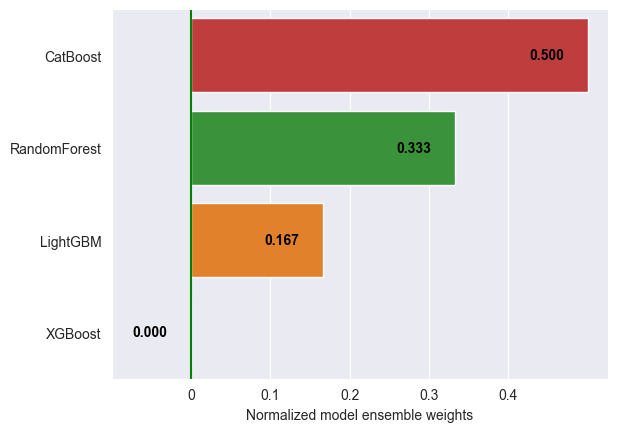

In [39]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights)
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

# Feature Importance

In [40]:
def make_predictions(x):
    prediction = 0

    for model_id in range(len(supported_models)):
        for pipeline in train_results[f'{supported_models[model_id]}_pipelines']:
            prediction += np.array(pipeline.predict(x)).flatten() * optimal_model_weights[model_id] * 0.2

    return prediction

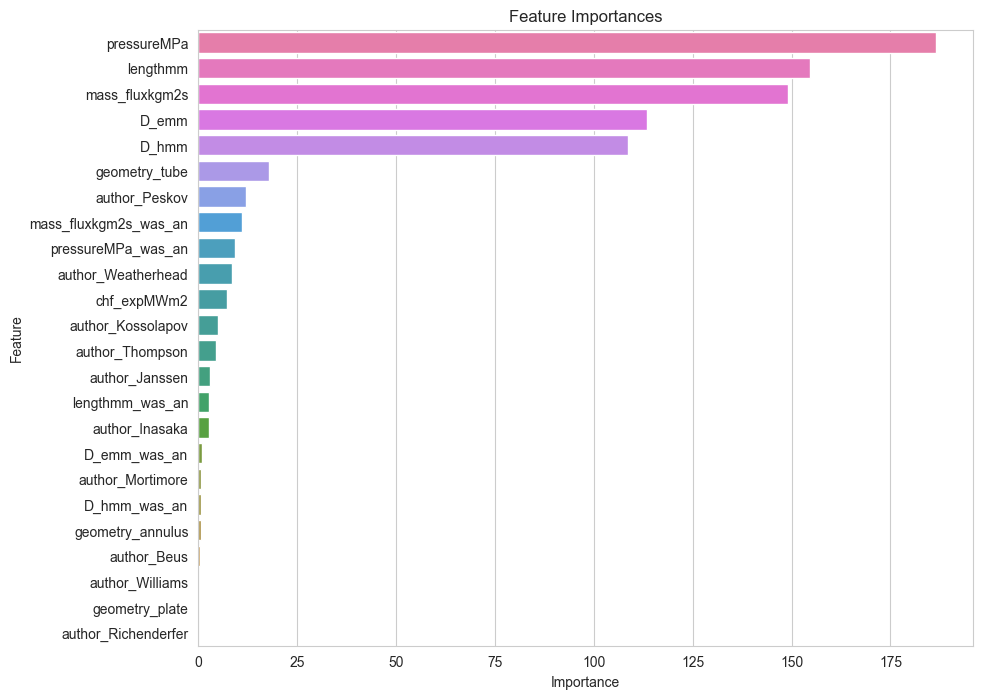

In [41]:
# Get feature importance
importance = train_results['LightGBM_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_pipelines'])):
    importance += train_results['LightGBM_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('x_e_out', axis=1).columns.values

# Create a dataframe of feature importance
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
# Sort features by importance
df_importance = df_importance.sort_values('importance', ascending=False)

# Create horizontal bar plot of feature importance
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [42]:
def get_split_data(eval_sets_idx) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_all_data: pd.DataFrame = None
    for eval_set in eval_sets_idx:
        if df_all_data is None:
            df_all_data = df_train.iloc[eval_set]
        else:
            df_all_data = pd.concat([df_all_data, df_train.iloc[eval_set]])

    df_eval_given: pd.DataFrame = df_all_data[df_all_data.index < len(df_data)]
    df_eval_original: pd.DataFrame = df_all_data[df_all_data.index >= len(df_data)]

    return df_eval_given, df_eval_original

In [43]:
def graph_predictions_vs_true() -> None:
    # All model should have the exact same eval sets
    df_eval_given, df_eval_original = get_split_data(train_results['LightGBM_eval_sets'])

    graph_data = {
        "data": [df_eval_given, df_eval_original],
        "name": ['given', 'original']
    }

    for data, name in zip(graph_data['data'], graph_data['name']):
        X = data.drop('x_e_out', axis=1)
        y = data['x_e_out']
        y_predicted = make_predictions(X)
        data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
        sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
    plt.title("True vs Predicted")
    plt.legend()

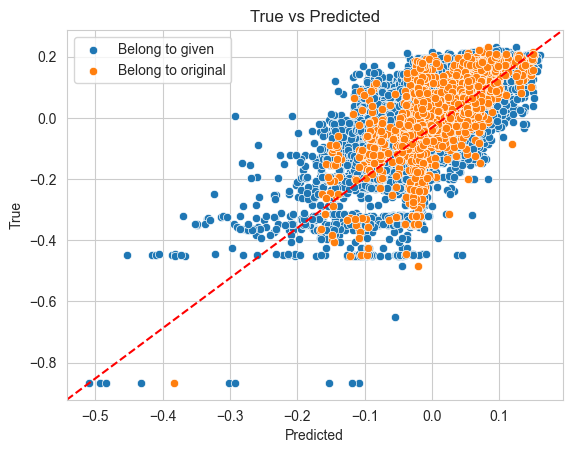

In [44]:
graph_predictions_vs_true()

# Make predictions

In [45]:
df_test = df_test.drop('x_e_out', axis=1)

In [46]:
predictions = make_predictions(df_test)

In [47]:
df_test['x_e_out [-]'] = predictions

In [48]:
df_test['x_e_out [-]'].to_csv("submission.csv", index=True, index_label='id')